<a href="https://colab.research.google.com/github/BrunoMarins/puc_data_science/blob/main/MVP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP2 – Machine Learning & Analytics
## Aluno: Bruno Marins Soares

Tempo aproximado de execução da seção A sem aceleração de hardware = 10 min

Tempo aproximado de execução da seção B sem aceleração de hardware = 15 min

Tempo total aproximado de execução deste notebook sem aceleração de hardware = 25 min

#A) ML clássico para problema de classificação

## 1) Definição do problema


A partir de dados de campanhas de marketing baseadas em chamadas telefônicas de uma instituição bancária portuguesa (https://archive.ics.uci.edu/dataset/222/bank+marketing), pretende-se **prever se o cliente irá ou não subscrever em uma oferta de depósito a prazo**. O *dataset* é composto por **4521 exemplos e 17 atributos**:

**age** - (numeric)

**job** -  type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

**marital** - marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

**education** - (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

**default** - has credit in default? (categorical: 'no','yes','unknown')

**balance** - average annual balance in euros in the client's bank account

**housing** - has housing loan? (categorical: 'no','yes','unknown')

**loan** -  has personal loan? (categorical: 'no','yes','unknown')

**contact** -  contact communication type (categorical: 'cellular','telephone')

**month** - last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

**day_of_week** -  last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

**duration** - last contact duration, in seconds (numeric)

**campaign** - number of contacts performed during this campaign and for this client (numeric, includes last contact)

**pdays** - number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted)

**previous** - number of contacts performed before this campaign and for this client (numeric)

**poutcome** - outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

**y** - has the client subscribed a term deposit? (binary: 'yes','no')

## 2) Preparação de dados

### 2.1) Importação e limpeza

In [ ]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [ ]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/BrunoMarins/puc_data_science/main/bank.csv"

# Lê o arquivo
dt = pd.read_csv(url, delimiter=';')

# Mostra as primeiras linhas do dataset
dt.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [ ]:
# verificando informações de dimensão, quantidade de nulos e os tipos de dado em cada coluna
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


Não há nulos mas há atributos categóricos que exigirão tratamento para serem consumidos na fase de modelagem.

In [ ]:
# Transformando previamente y em numérico para análise
dt['y'].replace({'no': 0, 'yes': 1}, inplace=True)

In [ ]:
# verificando o sumário estatístico dos atributos numéricos
dt.describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579,0.115240
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562,0.319347
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000,1.000000


Os atributos numericos possivelmente se beneficiarão de normalização/padronização. Os atributos "campaign", "pdays" e "previous" possuem distribuição bastante assimétrica e há um desbalanceamento acentuado de classes (diferença de frequencia dos valores de y) o que nos compele a usar uma validação cruzada estratificada.

### 2.2) Separação em treino e teste

In [ ]:
# Separação dos inputs e outputs
X = dt.drop('y', axis=1)
y = dt['y']

seed = 7 # semente aleatória
test_size = 0.20 # tamanho do conjunto de teste

# Separação em conjuntos de treino e teste
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

### 2.3) Tratamento e seleção de atributos

In [ ]:
# Transformando os atributos categóricos em one hot encoding

# Salvando listas de atributos numéricos e categóricos
numeric_cols = list(X.select_dtypes(include=['int']).columns)
categorical_cols = list(X.select_dtypes(include=['object']).columns)

# Criando o objeto encoder
encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')

# Ajustando o encoder e trasformando o conjunto de treino
X_train_cat_encod = encoder.fit_transform(X_train_raw[categorical_cols])
new_cat_columns = encoder.get_feature_names_out()
X_train_cat_encod = pd.DataFrame(X_train_cat_encod, columns=new_cat_columns )
X_train_num = X_train_raw[numeric_cols].reset_index()
X_train = pd.concat([X_train_num, X_train_cat_encod], axis=1, join='outer')

In [ ]:
# Transformando o conjunto de teste
X_test_cat_encod  = encoder.transform(X_test_raw[categorical_cols])
X_test_cat_encod = pd.DataFrame(X_test_cat_encod, columns=new_cat_columns )
X_test_num = X_test_raw[numeric_cols].reset_index()
X_test = pd.concat([X_test_num, X_test_cat_encod], axis=1, join='outer')

In [ ]:
# Selecionando atributos

# Criando o objeto SelectKBest
selector = SelectKBest(score_func=f_classif)

# Ajustando o selector e trasformando o conjunto de treino
X_train_sel = selector.fit_transform(X_train, y_train)

# Transformando o conjunto de teste
X_test_sel = selector.transform(X_test)

# Obtendo os índices dos atributos selecionados
selected_features = selector.get_support(indices=True)

# Imprimindo os índices dos recursos selecionados
print("Atributos selecionados:", X_train.columns[selected_features])

Atributos selecionados: Index(['duration', 'pdays', 'previous', 'housing_yes', 'contact_unknown',
       'month_mar', 'month_may', 'month_oct', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


## 3) Modelagem e treinamento

###3.1) Construção e avaliação dos modelos sem seleção de atributos

LR-orig: 0.892 (0.013)
KNN-orig: 0.879 (0.007)
CART-orig: 0.860 (0.014)
NB-orig: 0.847 (0.015)
SVM-orig: 0.885 (0.001)
Bag-orig: 0.892 (0.012)
RF-orig: 0.893 (0.010)
ET-orig: 0.890 (0.010)
Ada-orig: 0.891 (0.012)
GB-orig: 0.897 (0.014)
Vot-orig: 0.886 (0.011)
LR-padr: 0.903 (0.011)
KNN-padr: 0.886 (0.011)
CART-padr: 0.863 (0.016)
NB-padr: 0.845 (0.015)
SVM-padr: 0.887 (0.008)
Bag-padr: 0.896 (0.013)
RF-padr: 0.893 (0.010)
ET-padr: 0.889 (0.011)
Ada-padr: 0.891 (0.012)
GB-padr: 0.897 (0.014)
Vot-padr: 0.896 (0.011)
LR-norm: 0.899 (0.010)
KNN-norm: 0.881 (0.006)
CART-norm: 0.863 (0.014)
NB-norm: 0.845 (0.015)
SVM-norm: 0.892 (0.007)
Bag-norm: 0.895 (0.016)
RF-norm: 0.892 (0.008)
ET-norm: 0.890 (0.011)
Ada-norm: 0.891 (0.012)
GB-norm: 0.897 (0.014)
Vot-norm: 0.895 (0.009)


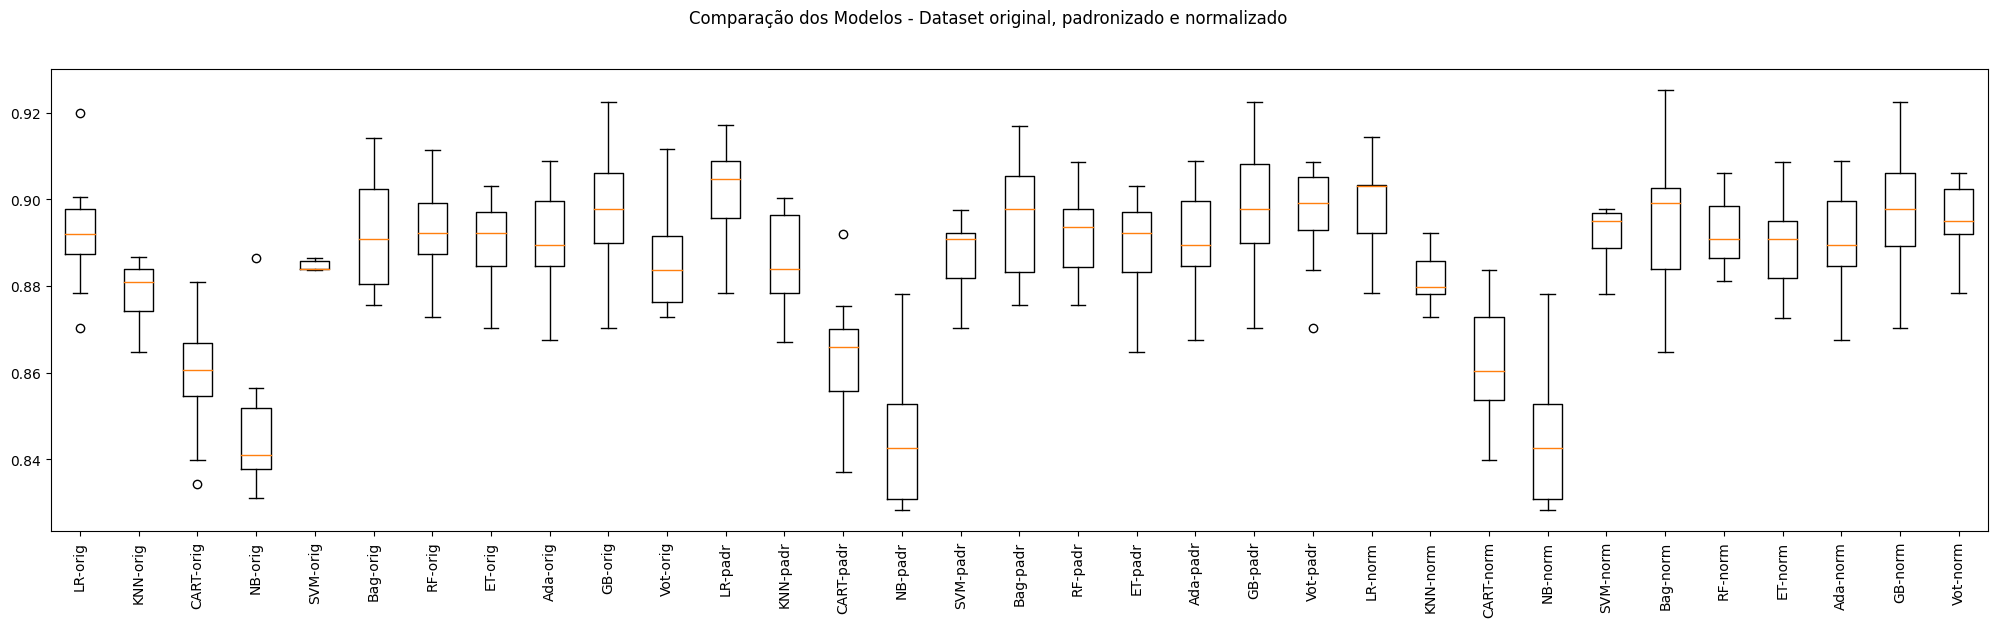

In [ ]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(base_estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset original, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

###3.2) Avaliação dos modelos com atributos selecionados

LR-orig: 0.903 (0.012)
KNN-orig: 0.887 (0.014)
CART-orig: 0.877 (0.014)
NB-orig: 0.884 (0.017)
SVM-orig: 0.890 (0.010)
Bag-orig: 0.888 (0.010)
RF-orig: 0.889 (0.012)
ET-orig: 0.881 (0.016)
Ada-orig: 0.901 (0.012)
GB-orig: 0.901 (0.013)
Vot-orig: 0.902 (0.010)
LR-padr: 0.902 (0.011)
KNN-padr: 0.893 (0.017)
CART-padr: 0.879 (0.015)
NB-padr: 0.884 (0.017)
SVM-padr: 0.893 (0.013)
Bag-padr: 0.891 (0.012)
RF-padr: 0.886 (0.014)
ET-padr: 0.880 (0.015)
Ada-padr: 0.901 (0.011)
GB-padr: 0.901 (0.013)
Vot-padr: 0.900 (0.013)
LR-norm: 0.898 (0.010)
KNN-norm: 0.892 (0.015)
CART-norm: 0.878 (0.014)
NB-norm: 0.884 (0.017)
SVM-norm: 0.894 (0.007)
Bag-norm: 0.891 (0.012)
RF-norm: 0.887 (0.013)
ET-norm: 0.881 (0.016)
Ada-norm: 0.901 (0.012)
GB-norm: 0.901 (0.013)
Vot-norm: 0.895 (0.010)


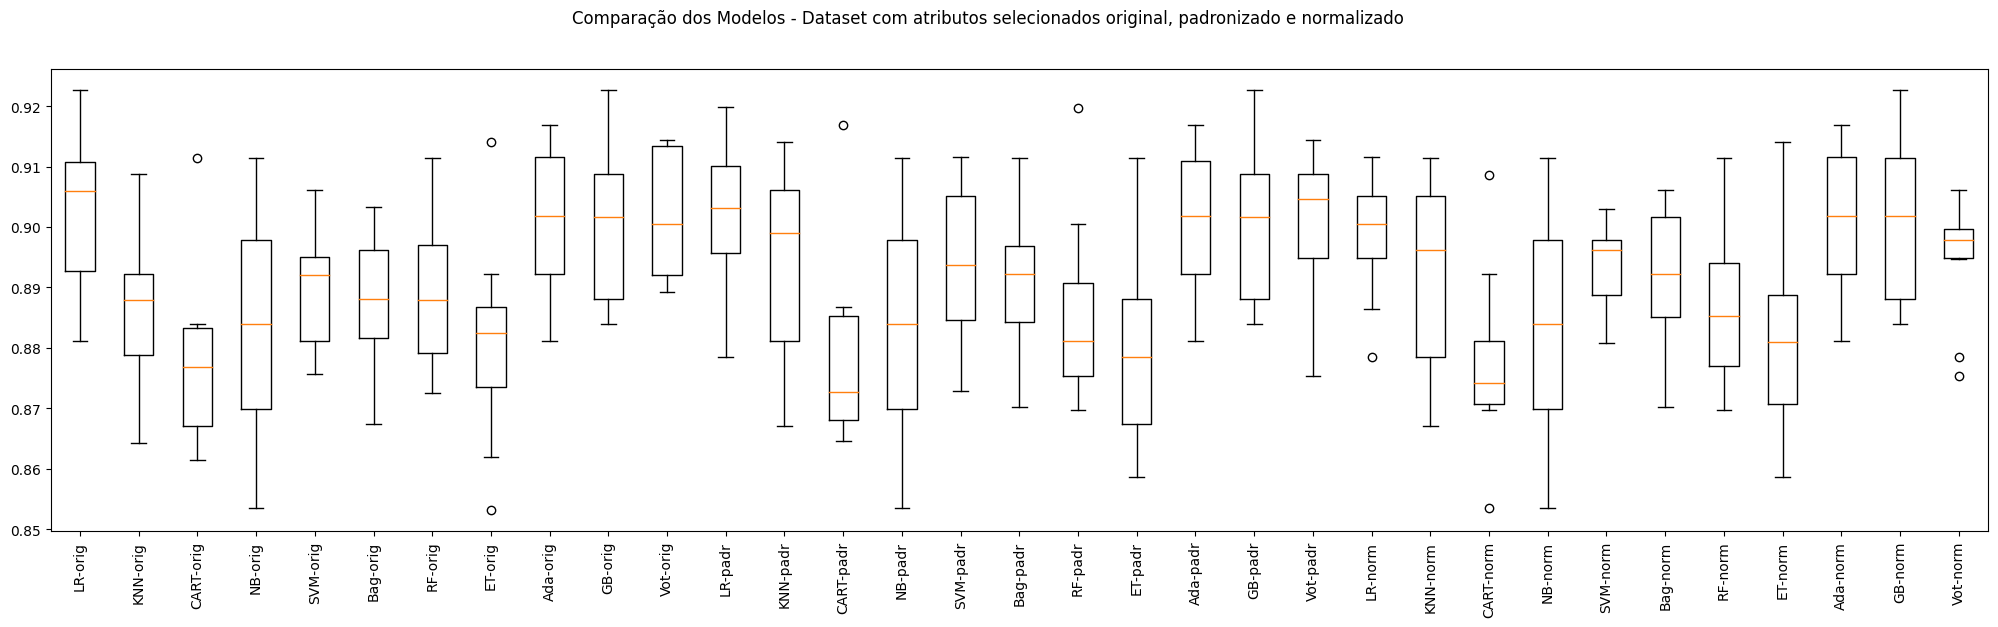

In [ ]:
np.random.seed(7) # definindo uma semente global para este bloco

# Reinicializando listas para armazenar os resultados para o mesmo pipeline porém com o dataset de atributos selecionados
results = []
names = []

# Reexecutando os pipelines com o datase de atributos selecionados
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train_sel, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset com atributos selecionados original, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### 3.3) Otimização de hiperparâmetros

A seguir tentaremos melhorar ainda mais os resultados dos métodos LR, Ada e GB usando os dados originais comparados aos dados padronizados e normalizados e variando alguns hiperparâmetros.

In [ ]:
# Tuning do LR

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
reg_log = ('LR', LogisticRegression(max_iter=200))
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('LR-orig', Pipeline(steps=[reg_log])))
pipelines.append(('LR-padr-norm', Pipeline(steps=[standard_scaler, min_max_scaler, reg_log])))


param_grid = {
    'LR__C': [0.01, 0.1, 1, 10, 100],
    'LR__penalty': ["l1", "l2", "none"],
    'LR__solver': ["liblinear", "lbfgs", "sag", "newton-cg"]
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train_sel, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: LR-orig - Melhor: 0.903205 usando {'LR__C': 1, 'LR__penalty': 'l2', 'LR__solver': 'liblinear'}
Sem tratamento de missings: LR-padr-norm - Melhor: 0.902378 usando {'LR__C': 100, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}


In [ ]:
# Tuning do ADA

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
ada_boost = ('Ada', AdaBoostClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('Ada-orig', Pipeline(steps=[ada_boost])))
pipelines.append(('Ada-padr-norm', Pipeline(steps=[standard_scaler, min_max_scaler, ada_boost])))

param_grid = {
    'Ada__n_estimators': [100, 200, 300],
    'Ada__learning_rate': [0.02, 0.1, 0.5]
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train_sel, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: Ada-orig - Melhor: 0.904586 usando {'Ada__learning_rate': 0.1, 'Ada__n_estimators': 300}
Sem tratamento de missings: Ada-padr-norm - Melhor: 0.904586 usando {'Ada__learning_rate': 0.1, 'Ada__n_estimators': 300}


In [ ]:
# Tuning do GB

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
grad_boost = ('GB', GradientBoostingClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('GB-orig', Pipeline(steps=[grad_boost])))
pipelines.append(('GB-padr-norm', Pipeline(steps=[standard_scaler, min_max_scaler, grad_boost])))

param_grid = {
    'GB__n_estimators': [25, 50, 100],
    'GB__max_depth': [3, 5, 7]
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train_sel, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: GB-orig - Melhor: 0.905145 usando {'GB__max_depth': 5, 'GB__n_estimators': 25}
Sem tratamento de missings: GB-padr-norm - Melhor: 0.903761 usando {'GB__max_depth': 5, 'GB__n_estimators': 25}


### 3.4) Construção, treinamento e avaliação de um modelo final

Vot-orig: 0.903 (0.012)
Vot-pad: 0.902 (0.012)
Vot-norm: 0.903 (0.010)
Vot-pad-norm: 0.903 (0.010)


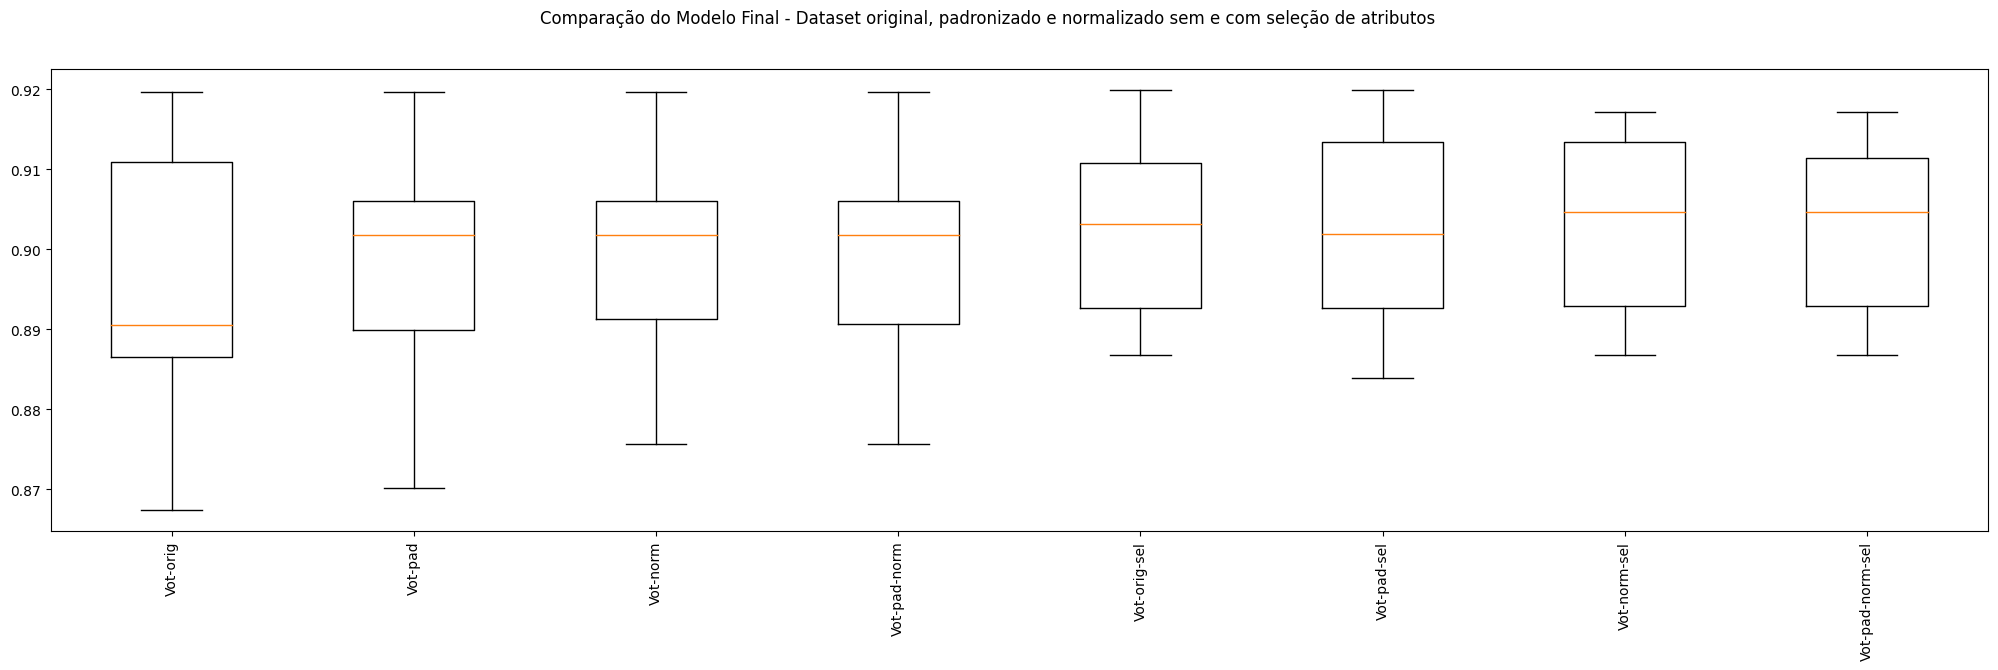

In [ ]:
# Treinando um novo Voting Ensemble com base nos 3 melhores (LR, Ada e GB)

np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Definindo parâmetros
num_trees = 100

# Criando os modelos para o VotingClassifier
bases2 = []
model1 = LogisticRegression(max_iter=200)
bases2.append(('lr', model1))
model2 = AdaBoostClassifier(n_estimators=num_trees)
bases2.append(('ada', model2))
model3 = GradientBoostingClassifier(n_estimators=num_trees)
bases2.append(('gb', model3))

voting2 = ('Voting', VotingClassifier(bases2))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines
pipelines.append(('Vot-orig', Pipeline([voting2])))
pipelines.append(('Vot-pad', Pipeline([standard_scaler, voting2])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting2])))
pipelines.append(('Vot-pad-norm', Pipeline([standard_scaler, min_max_scaler, voting2])))

# Executando os pipelines sem seleção de atributos
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    #print(msg)

# Executando os pipelines com seleção de atributos
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train_sel, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name + "-sel")
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação do Modelo Final - Dataset original, padronizado e normalizado sem e com seleção de atributos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

## 4) Avaliação de resultados

### 4.1) Avaliação do modelo escolhido com a base de teste

In [ ]:
# Preparação do modelo
pipeline = Pipeline([standard_scaler, min_max_scaler])
scaler = pipeline.fit(X_train_sel) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train_sel) # aplicação da padronização no conjunto de treino
model = voting2[1]
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test_sel) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.8972375690607735


### 4.2) Preparação do modelo escolhido com toda a base de dados

In [ ]:
X_sel = np.vstack([X_train_sel,X_test_sel])
y_sel = np.hstack([y_train,y_test])
scaler = pipeline.fit(X_sel) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X_sel) # aplicação do scaler a TODO o dataset
model.fit(rescaledX, y_sel)

VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=200)),
                             ('ada', AdaBoostClassifier(n_estimators=100)),
                             ('gb', GradientBoostingClassifier())])

### 4.3) Simulação de utilização do modelo

In [ ]:
# Atributos selecionados e utilizados no modelo final
sel_feat = ['duration', 'pdays', 'previous', 'housing_yes', 'contact_unknown',
       'month_mar', 'month_may', 'month_oct', 'poutcome_success',
       'poutcome_unknown']

data = {'duration':  [3, 185, 600],
        'pdays': [30, -1, 32],
        'previous': [6, 0, 11],
        'housing_yes': [1, 0, 0],
        'contact_unknown': [0, 1, 0],
        'month_mar': [1, 0, 0],
        'month_may': [0, 1, 0],
        'month_oct': [0, 0, 1],
        'poutcome_success': [0, 0, 1],
        'poutcome_unknown': [1, 0, 0],
        }

entrada = pd.DataFrame(data, columns=sel_feat)
array_entrada = entrada.values
X_entrada = array_entrada[:,0:10].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)

# Predição de classes dos dados de entrada (0 = rejeita o serviço, 1 = contrata o serviço)
saidas = model.predict(rescaledEntradaX)
print(saidas)

[0 0 1]


### 4.4) Conclusão

Dentre os diferentes modelos e transformações de dados avaliados, observamos que:

1) padronizar e/ou normalizar os dados melhorou sensivelmente os resultados;

2) selecionar os atributos (10 de 43 pós-codificação) melhorou significativamente os resultados, particularmente para os métodos DecisionTreeClassifier e NaiveBayes;

3) a tentativa de otimização de hiperparâmetros para os métodos que tinham os melhores resultados (LogisticRegression, AdaBoost e GradientBoosting) não teve retorno apreciável.

Decidiu-se por treinar um *Voting Ensemble* com base nos 3 métodos com os melhores resultados (citados no item 3 acima), o que resultou em acurácia comparável/sensivelmente melhor (média = 90,3% e desvio padrão = 1,0%) que os melhores modelos anteriores. O modelo final foi então confrontado com a base de teste apresentando 89,7% de acurácia, similar ao treinamento, o que pressupoê um *fitting* adequado e ausência de problemas como *data leakage*. Por fim, o modelo foi treinado com todo o conjunto de dados e seu uso simulado, estando pronto para implantação.

#B) DNN para problema de NLP

## 1) Definição do problema


A partir de um conjunto de dados compilado pela *Stanford University* de avaliações de filmes feitas por usuários do IMDb (*Internet Move Database*), utilizaremos ferramentas de NLP (*Natural Language Processing*) e treinaremos um modelo baseado em DNN (*Deep Neural Network*) para classificação de sentimentos.

O *dataset* está disponível na biblioteca Keras e possui 50 mil avaliações (divididas em 2 partes iguais: avaliações altamente polarizadas e demais avaliações) e 2 atributos:

***reviews*** - texto em inglês codificado como uma sequência de índices de palavras na forma de inteiros. As palavras dentro das avaliações são indexadas com base em sua frequência geral no conjunto de dados. Por exemplo, o inteiro "2" codifica a segunda palavra mais frequente nos dados

***sentiments*** - binário 1 (avaliação positiva) ou 0 (avaliação negativa)

## 2) Preparação de dados

### 2.1) Importação e limpeza

In [3]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
from keras.datasets import imdb #módulo com o dataset

In [4]:
# importando e concatenado as 2 partes do dataset (25 mil avaliações polarizadas e 25 mil demais)
num_words=10000 # limita o vocabulário importado a 10 mil palavras mais frequentes, as demais são substituídas por #
(training_data, training_targets), (testing_data, testing_targets) = imdb.load_data(num_words=num_words)
X_coded = np.concatenate((training_data, testing_data), axis=0)
y_full = np.concatenate((training_targets, testing_targets), axis=0)

In [5]:
# decodificando reviews (as palavras são inteiros, 1 = palavra mais frequente no corpus, 2 = segunda mais frequente, etc.)
index = imdb.get_word_index() # dicionário para decodificar os reviews
reverse_index = dict([(value, key) for (key, value) in index.items()]) # inverte chaves e valores para decodificação
X_decoded = []
X_decoded_filtered = []
X_decoded_plain = []
for code in X_coded:
  word_list = [reverse_index.get(i - 3, "#") for i in code] # lista de palavras na ordem original de cada review
  X_decoded.append(word_list) # review recomposta em uma lista de palavras
  X_decoded_plain.append(" ".join(word_list)) # review recomposta em texto corrido

In [6]:
print(X_decoded[1][:22])

['#', 'big', 'hair', 'big', 'boobs', 'bad', 'music', 'and', 'a', 'giant', 'safety', 'pin', 'these', 'are', 'the', 'words', 'to', 'best', 'describe', 'this', 'terrible', 'movie']


In [7]:
X_decoded_plain[1][:110]

'# big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie'

Utilizaremos uma amostra aleatória de 5 mil dos 50 mil reviews para o projeto não consumir muito tempo de execução.

In [8]:
import random
random.seed(7)
random_idx = random.sample(range(50000), 5000) # cria lista aleatória de 5 mil números entre 0 e 49 mil)
X = [X_decoded_plain[i] for i in random_idx]
y = [y_full[i] for i in random_idx]

### 2.2) Separação em treino e teste

In [9]:
from sklearn.model_selection import train_test_split, StratifiedKFold

seed = 7 # semente aleatória
test_size = 0.20 # tamanho do conjunto de teste

# Separação em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

#verificando balanceamento de classes dentre 4 mil reviews de treino
sum(y_train)

# # Parâmetros e partições da validação cruzada
# scoring = 'accuracy'
# num_particoes = 10
# kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

2000

Não há desbalanceamento de classes, por isso, por simplificação, decidiu-se dispensar a validação cruzada.

### 2.3) Tratamento e seleção de atributos

Inicialmente nesta seção, construiremos uma versão de *dataset* com remoção de caracteres especiais e pontuação, "tokenização" (texto para lista de palavras), remoção de *stopwords* (artigos, preposições, etc.) e "lemmatização" (radical da palavra) dos *reviews*.

In [10]:
import nltk
import spacy
import re
spacy.cli.download("en_core_web_sm")
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [11]:
def clean(doc):
  doc = re.sub(r'[^\w\s]', ' ', doc).lower() #remove caracteres não-alfa numéricos e torna as letras minúsculas
  doc = nlp(doc) # tornando o documento um objeto spacy
  lemma_list = [token.lemma_.replace(' ','') for token in doc if not token.is_stop] # remove stopwords e lemmatiza
  lemma_list = list(filter(lambda lemma: len(lemma) > 2 or lemma.isdigit(), lemma_list)) # retém lemmas com mais de 2 caracteres e números
  return ' '.join(lemma_list) # retorna lista de lemmas

In [12]:
# testando função
clean("Test it on. Do it @ or there's no way to not get in trouble for that! # reviewing/reviews, 3;")

'test way trouble review review 3'

In [13]:
# limpando os reviews
X_train_clean = []
for review in X_train:
  X_train_clean.append(clean(review))

X_test_clean = []
for review in X_test:
  X_test_clean.append(clean(review))

In [14]:
print(X_train_clean[0])

bad piece garbage see heath ledger look wish know item real life spend 2 long hour life wonder see orlando bloom beard deer look agree rachel usual fabulous self geoffrey rush look couldn wait set suppose feel sorry murderer far cry butch cassidy actually entertaining film trite cliche ride bore stay convince well didn 10 15 minute unintentionally hilarious heath gang frontier hotel woman child die presence funny funny walk hotel armor think black knight monty python holy grail keep wait bite leg howl laughter member audience leave pretty talk waste time film pay cash disaster sneak preview certainly wasn free cost 2 hour life


Agora processaremos os *datasets* para produzir uma vetorização por contagem (uma das técnicas de *bag of words* - BOW).

In [15]:
# bag of words
from sklearn.feature_extraction.text import CountVectorizer

# Cria uma instância do CountVectorizer
vectorizer = CountVectorizer()
vectorizer_clean = CountVectorizer()

# Aprende o vocabulário e transforma reviews em vetores de contagem
X_train_bow = np.array(vectorizer.fit_transform(X_train).todense())
X_test_bow = np.array(vectorizer.transform(X_test).todense())

X_train_clean_bow = np.array(vectorizer_clean.fit_transform(X_train_clean).todense())
X_test_clean_bow = np.array(vectorizer_clean.transform(X_test_clean).todense())

# Armazena os novos atributos (vocabulário) em um dicionário
vocab = vectorizer.vocabulary_
vocab_clean = vectorizer_clean.vocabulary_

In [16]:
# Verificando resultado da vetorização

# Componente vetorial (atributo) que representa uma palavra do vocabulário
word_id = vocab['visceral']
print(word_id)

9297


Por fim, processaremos os *datasets* usando Doc2Vec (vetorização mais avançada que busca representar o "sentido e intensidade semântica" de um documento em relação ao corpus de documentos e o *tagging* atribuído).

In [17]:
# Doc2Vec

# Imports necessários
from gensim.models import doc2vec
from scipy import spatial

# Instanciando modelos
doc2_mod = doc2vec.Doc2Vec(vector_size=200, window=5, min_count=1, workers=4, alpha=0.025, seed=7)
doc2_clean_mod = doc2vec.Doc2Vec(vector_size=200, window=5, min_count=1, workers=4, alpha=0.025, seed=7)

# função para tokenizar texto, necessária para criar vocabulário doc2vec
def to_tokens(text_list):
  tokenlist_list = []
  for text in text_list:
    doc = nlp(text)
    tokenlist_list.append([str(token) for token in doc])
  return tokenlist_list

# construindo versões tokenizadas dos datasets
X_train_tokens = to_tokens(X_train)
X_train_clean_tokens = to_tokens(X_train_clean)
X_test_tokens = to_tokens(X_test)
X_test_clean_tokens = to_tokens(X_test_clean)

# criando sentenças taggeadas para construir os vocabulários
tagged_sentences = [doc2vec.TaggedDocument(words=doc, tags=[str(y)]) for doc, y in zip(X_train_tokens, y_train)]
tagged_sentences_clean = [doc2vec.TaggedDocument(words=doc, tags=[str(y)]) for doc, y in zip(X_train_clean_tokens, y_train)]

# construindo vocabulários
doc2_mod.build_vocab(tagged_sentences)
doc2_clean_mod.build_vocab(tagged_sentences_clean)

In [18]:
# treinando modelos
doc2_mod.train(tagged_sentences, total_examples=doc2_mod.corpus_count, epochs=doc2_mod.epochs)
doc2_clean_mod.train(tagged_sentences_clean, total_examples=doc2_clean_mod.corpus_count, epochs=doc2_clean_mod.epochs)

In [19]:
# datasets vetorizados
X_train_d2v = np.array([doc2_mod.infer_vector(doc) for doc in X_train_tokens])
X_test_d2v = np.array([doc2_mod.infer_vector(doc) for doc in X_test_tokens])

X_train_clean_d2v = np.array([doc2_clean_mod.infer_vector(doc) for doc in X_train_clean_tokens])
X_test_clean_d2v = np.array([doc2_clean_mod.infer_vector(doc) for doc in X_test_clean_tokens])

## 3) Modelagem e treinamento

###3.1) Construção e avaliação dos modelos

Treinamento e teste de um modelo para BOW:

In [20]:
np.random.seed(7) # definindo uma semente global para este bloco

# imports necessários
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Função que cria o modelo DNN
def create_model(num_feat, inner_layers=1, inner_neurons=32, drop=0.5, inner_activ_func='relu', out_activ_func='sigmoid',
                 loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']):
  model = Sequential()
  model.add(Dense(num_feat, activation=inner_activ_func))
  for i in range(inner_layers):
    model.add(Dense(inner_neurons, activation=inner_activ_func))
    model.add(Dropout(drop))
  model.add(Dense(1, activation=out_activ_func))
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
  return model

# instanciando normalizador
norm =  MinMaxScaler()

# convertendo alvos de treino e teste para numpy array
y_model = np.array(y_train)
y_model_test = np.array(y_test)

In [31]:
# normalização e redução de dimensionalidade para uso dataset BOW
pca = PCA()
X_model = pca.fit_transform(norm.fit_transform(X_train_bow))
X_model_test = pca.transform(norm.fit_transform(X_test_bow))

In [32]:
# criação do modelo
model = create_model(X_model.shape[1])

# treinamento
model.fit(X_model, y_model, epochs=4, batch_size=1024, validation_data=(X_model_test, y_model_test))

Epoch 1/4
4/4 [==============================] - 8s 2s/step - loss: 0.6833 - accuracy: 0.5740 - val_loss: 0.6157 - val_accuracy: 0.8220
Epoch 2/4
4/4 [==============================] - 5s 1s/step - loss: 0.5191 - accuracy: 0.8755 - val_loss: 0.4840 - val_accuracy: 0.8550
Epoch 3/4
4/4 [==============================] - 6s 2s/step - loss: 0.3083 - accuracy: 0.9600 - val_loss: 0.3742 - val_accuracy: 0.8550
Epoch 4/4
4/4 [==============================] - 5s 1s/step - loss: 0.1362 - accuracy: 0.9915 - val_loss: 0.3476 - val_accuracy: 0.8430


Treinamento e teste de um modelo para BOW com tratamentos (versão "clean"):

In [23]:
# normalização e redução de dimensionalidade para uso dataset BOW tratado (clean)
pca_clean = PCA()
X_model = pca_clean.fit_transform(norm.fit_transform(X_train_clean_bow))
X_model_test = pca_clean.transform(norm.fit_transform(X_test_clean_bow))

In [24]:
# criação do modelo
model = create_model(X_model.shape[1])

# treinamento
model.fit(X_model, y_model, epochs=3, batch_size=1024, validation_data=(X_model_test, y_model_test))

Epoch 1/3
4/4 [==============================] - 8s 2s/step - loss: 0.6832 - accuracy: 0.5847 - val_loss: 0.6291 - val_accuracy: 0.8190
Epoch 2/3
4/4 [==============================] - 6s 2s/step - loss: 0.5605 - accuracy: 0.8708 - val_loss: 0.5260 - val_accuracy: 0.8310
Epoch 3/3
4/4 [==============================] - 6s 2s/step - loss: 0.3872 - accuracy: 0.9467 - val_loss: 0.4205 - val_accuracy: 0.8400


Treinamento e teste de um modelo para Doc2Vec:

In [25]:
# normalização para uso do dataset Doc2Vec
X_model = norm.fit_transform(X_train_d2v)
X_model_test = norm.fit_transform(X_test_d2v)

In [26]:
# criação do modelo
model = create_model(X_model.shape[1])

# treinamento
model.fit(X_model, y_model, epochs=12, batch_size=512, validation_data=(X_model_test, y_model_test))

Epoch 1/12
8/8 [==============================] - 2s 50ms/step - loss: 0.7341 - accuracy: 0.5002 - val_loss: 0.6899 - val_accuracy: 0.5140
Epoch 2/12
8/8 [==============================] - 0s 15ms/step - loss: 0.6869 - accuracy: 0.5395 - val_loss: 0.6851 - val_accuracy: 0.5430
Epoch 3/12
8/8 [==============================] - 0s 16ms/step - loss: 0.6775 - accuracy: 0.5720 - val_loss: 0.6685 - val_accuracy: 0.6620
Epoch 4/12
8/8 [==============================] - 0s 18ms/step - loss: 0.6616 - accuracy: 0.6135 - val_loss: 0.6536 - val_accuracy: 0.7380
Epoch 5/12
8/8 [==============================] - 0s 18ms/step - loss: 0.6406 - accuracy: 0.6967 - val_loss: 0.6419 - val_accuracy: 0.7310
Epoch 6/12
8/8 [==============================] - 0s 11ms/step - loss: 0.6201 - accuracy: 0.7078 - val_loss: 0.6227 - val_accuracy: 0.6930
Epoch 7/12
8/8 [==============================] - 0s 10ms/step - loss: 0.5990 - accuracy: 0.7340 - val_loss: 0.6011 - val_accuracy: 0.7940
Epoch 8/12
8/8 [===========

Treinamento e teste de um modelo para Doc2Vec com tratamentos (versão "clean"):

In [27]:
# normalização para uso do dataset Doc2Vec tratado (clean)
X_model = norm.fit_transform(X_train_clean_d2v)
X_model_test = norm.fit_transform(X_test_clean_d2v)

In [28]:
# criação do modelo
model = create_model(X_model.shape[1])

# treinamento
model.fit(X_model, y_model, epochs=8, batch_size=512, validation_data=(X_model_test, y_model_test))

Epoch 1/8
8/8 [==============================] - 1s 33ms/step - loss: 0.7232 - accuracy: 0.5120 - val_loss: 0.6695 - val_accuracy: 0.7230
Epoch 2/8
8/8 [==============================] - 0s 11ms/step - loss: 0.6576 - accuracy: 0.6447 - val_loss: 0.6351 - val_accuracy: 0.7970
Epoch 3/8
8/8 [==============================] - 0s 10ms/step - loss: 0.6201 - accuracy: 0.6963 - val_loss: 0.6024 - val_accuracy: 0.8160
Epoch 4/8
8/8 [==============================] - 0s 12ms/step - loss: 0.5822 - accuracy: 0.7477 - val_loss: 0.5691 - val_accuracy: 0.8070
Epoch 5/8
8/8 [==============================] - 0s 11ms/step - loss: 0.5402 - accuracy: 0.8033 - val_loss: 0.5337 - val_accuracy: 0.8170
Epoch 6/8
8/8 [==============================] - 0s 12ms/step - loss: 0.5057 - accuracy: 0.7887 - val_loss: 0.5100 - val_accuracy: 0.8160
Epoch 7/8
8/8 [==============================] - 0s 13ms/step - loss: 0.4646 - accuracy: 0.8313 - val_loss: 0.4949 - val_accuracy: 0.7830
Epoch 8/8
8/8 [===================

## 4) Avaliação de resultados

Apesar de requerer redução de dimensionalidade para um treinamento eficiente, o modelo para BOW com tratamentos ou não teve um resultado próximo, porém a versão sem tratamentos foi ligeiramente superior. Superou inclusive o Doc2Vec, quando verificado contra o *dataset* de teste na segunda iteração. Porém, na terceira iteração já apresenta indícios de *overfitting*, ou seja, melhoria do ajuste ao *dataset* de treino mas não ao de teste/validação.

### 4.1) Preparação do modelo escolhido com toda a base de dados

In [29]:
# concatenando para TODO o dataset
X_full = np.vstack([X_train_bow,X_test_bow])
y_full = np.hstack([y_train,y_test])

In [33]:
# normalização e redução de dimensionalidade para uso dataset BOW
pca = PCA()
X_model = pca.fit_transform(norm.fit_transform(X_full))
y_model = y_full

In [34]:
# criação do modelo
model = create_model(X_model.shape[1])

# treinamento
model.fit(X_model, y_model, epochs=2, batch_size=1024)

Epoch 1/2
5/5 [==============================] - 20s 3s/step - loss: 0.6803 - accuracy: 0.5958
Epoch 2/2
5/5 [==============================] - 14s 3s/step - loss: 0.5101 - accuracy: 0.8712


### 4.2) Simulação de utilização do modelo

In [35]:
# dados de entrada não vistos
txt1 = "Terrible, disgusting and nonsense film, the director had no idea of what he was doing"
txt2 = "I wasted my time seeing this crap, it's an awful movie"
txt3 = "Delighted with this wonderful and incredible production"
txt4 = "Unbelievably loving. Couldn't stop till the end"
txt5 = "I don't know for sure what is my feeling about it"
txts = [txt1,txt2,txt3,txt4,txt5]

# Predição de classes dos dados de entrada (0 = avaliação negativa, 1 = avaliação positiva)
outputs = []
for txt in txts:
  txt_vec = np.array(vectorizer.transform([txt]).todense())
  txt_vec_tf = pca.transform(norm.transform(txt_vec))
  outputs.append(int(np.round(model.predict(txt_vec_tf, verbose=0))))
print(outputs)


[0, 0, 1, 1, 1]


### 4.3) Conclusão

Dentre os diferentes modelos e transformações de dados avaliados, observamos que:

1) processar os textos limpando dados desnecessários produziu eficiência, mas não melhores resultados para este problema em específico.

2) o *bag of words* utilizando CountVectorizer teve melhor resultado ao ser testado do que a técnica Doc2Vec para este problema em específico.

3) apesar do melhor resultado, o BOW mostrou maior tendência para *overfitting* de forma que o número de iterações foi limitado para evitá-lo.

Decidiu-se por treinar um modelo final BOW por *CountVectorizer* com o *dataset* completo do projeto  (acurácia de 87,55% no treino e 85,50% no teste). Por fim, o modelo foi treinado com todo o conjunto de dados e seu uso simulado, estando pronto para implantação.